# ABC

Think Bayes, Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install libraries

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [2]:
# Get utils.py

import os

if not os.path.exists('utils.py'):
    !wget https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py

In [3]:
from utils import set_pyplot_params
set_pyplot_params()

In this chapter I describe my solution to a problem posed by a patient
with a kidney tumor. I think the problem is important and relevant to
patients with these tumors and doctors treating them.

And I think the solution is interesting because, although it is a
Bayesian approach to the problem, the use of Bayes's theorem is
implicit. I present the solution and my code; at the end of the chapter I will explain the Bayesian part.

If you want more technical detail than I present here, you can read my
paper on this work at <http://arxiv.org/abs/1203.6890>.

## The Kidney Tumor Problem

I am a frequent reader and occasional contributor to the online
statistics forum at <http://reddit.com/r/statistics>. 
In November 2011, I read the following message:

> "I have Stage IV Kidney Cancer and am trying to determine if the cancer formed before I retired from the military. ... Given the dates of retirement and detection is it possible to determine when there was a 50/50 chance that I developed the disease? Is it possible to determine the probability on the retirement date? My tumor was 15.5 cm x 15 cm at detection. Grade II."

I contacted the author of the message to get more information; I
learned that veterans get different benefits if it is "more likely than not" that a tumor formed while they were in military service (among other considerations).

Because renal tumors grow slowly, and often do not cause symptoms, they are sometimes left untreated. As a result, doctors can observe the rate of growth for untreated tumors by comparing scans from the same patient at different times. Several papers have reported these growth rates.

For my analysis I used data from a paper by [Zhang et al](https://pubs.rsna.org/doi/full/10.1148/radiol.2501071712). 
They report growth rates in two forms:

* Volumetric doubling time, which is the time it would take for a tumor to double in time.

* Reciprocal doubling time (RDT), which is the number of doublings per year.

The next section shows how we work with these growth rates.

## A Growth Model

We'll start with a simple model of tumor growth and gradually add complications.

For the simple model, we'll assume

* Tumors grow with a constant doubling time, and 

* They are roughly spherical in shape.

And I'll define three points in time:

* `t0` is when the tumor formed (soon I'll be more precise about what that means).

* `t1` is when my correspondent retired.

* `t2` is when the tumor was detected.

I learned from my correspondent that the time between `t1` and `t2` was 3291 days (about 9 years).

In [41]:
interval = 3291      # days

As an example, let's assume that the diameter of the tumor at `t1` was 1 cm.

In [42]:
d1 = 1      # cm

The following function computes the volume of a sphere with a given diameter.

In [43]:
import numpy as np

def calc_volume(diameter):
    """Converts a diameter to a volume.

    V = 4/3 pi (d/2)^3
    """
    factor = 4 * np.pi / 3
    return factor * (diameter/2.0)**3

So if we assume that the tumor is spherical, we can compute its volume at `t1`.

In [44]:
v1 = calc_volume(d1)
v1

0.5235987755982988

The median volume doubling time reported by Zhang et al. is 811 days.

In [45]:
median_doubling_time = 811       # days

So we can compute the number of doublings that would have happened in the given interval.

In [46]:
doublings = interval / median_doubling_time
doublings

4.057953144266338

Given `v1` and the number of doublings, we can compute the volume at `t2`.

In [47]:
v2 = v1 * 2**doublings
v2

8.720958899498342

We can use the following function to compute the diameter of a sphere with the given volume.

In [48]:
def calc_diameter(volume):
    """Converts a volume to a diameter.

    d = 2r = 2 * (3/4/pi V)^1/3
    """
    factor = 3 / np.pi / 4
    return 2 * (factor * volume)**(1/3)

Here's the volume of the tumor at `t2`:

In [49]:
d2 = calc_diameter(v2)
d2

2.553809740864908

So if the diameter of the tumor was 1 cm at `t1`, and it grew at the median rate, the diameter would be about 2.6 cm at `t2`.

## Working backwards

The example in the previous section demonstrates the growth model, but it doesn't answer the question my correspondent posed.

We can get a partial answer by starting at the end and working backwards; that is, given that the diameter of the tumor was 15.5 cm at `t2`, how big would it have been at `t1`, assuming that it grew at the median rate?

Here's the volume at `t2`:

In [50]:
d2 = 15.5
v2 = calc_volume(d2)
v2

1949.816390481115

Since we already know the number of doublings in the interval, we can compute the volume at `t1` like this:

In [51]:
v1 = v2 / 2**doublings
v1

117.06527762172266

And given `v1`, we can compute the corresponding diameter:

In [52]:
d1 = calc_diameter(v1)
d1

6.06936364599759

The diameter at `t1` would have been about 6 cm.
We can conclude:

* If the tumor grew at the median rate, it must have formed prior to `t1`.

* Or, if it formed after `t1`, it must have grown substantially faster than the median rate.

Based on these results, I concluded that is "more likely than not" that the tumor formed prior to the date of discharge, and on behalf of my correspondent, I wrote a letter explaining my
conclusions to the Veterans' Benefit Administration.

Later I told a friend, who is an oncologist, about my results. 
He was surprised by the growth rates I found and by what they imply about the ages of these tumors. 
He suggested that the results might be interesting to researchers and doctors.

But in order to make them useful, I wanted a more general model of the
relationship between age and size.

## A More General Model

Given the size of a tumor at time of diagnosis, we would like to know the distribution of its age.

To find it, we'll run simulations of tumor growth to get the distribution of size conditioned on age. 
Then we'll use a Bayesian approach to get the distribution of age conditioned on size.

The simulation starts with a small tumor and runs these steps:

1.  Choose a value from the distribution of growth rates.

2.  Compute the size of the tumor at the end of an interval.

3.  Repeat until the tumor exceeds the maximum relevant size.

So the first thing we need is the distribution of growth rates.

## Distribution of RDT

Using the figures in the paper by Zhange et al., I created an array, `rdt_sample`, that contains estimated values of RDT for the 53 patients in the study.

Again, RDT stands for "reciprocal doubling time", which is in doublings per year.
So if `rdt=1`, a tumor would double in volume one year.
If `rdt=2`, it would double twice; that is, the volume would quadruple.
And if `rdt=-1`, it would halve in volume.

In [18]:
# Data from the histogram in Figure 3

import numpy as np
from empiricaldist import Pmf

counts = [2, 29, 11, 6, 3, 1, 1]
rdts = np.arange(-1, 6) + 0.01
pmf_rdt = Pmf(counts, rdts)
pmf_rdt.normalize()

53

In [19]:
# Data from the scatter plot in Figure 4

rdts = [5.089,  3.572,  3.242,  2.642,  1.982,  1.847,  1.908,  1.798,
        1.798,  1.761,  2.703, -0.416,  0.024,  0.869,  0.746,  0.257,
        0.269,  0.086,  0.086,  1.321,  1.052,  1.076,  0.758,  0.587,
        0.367,  0.416,  0.073,  0.538,  0.281,  0.122, -0.869, -1.431,
        0.012,  0.037, -0.135,  0.122,  0.208,  0.245,  0.404,  0.648,
        0.673,  0.673,  0.563,  0.391,  0.049,  0.538,  0.514,  0.404,
        0.404,  0.33,  -0.061,  0.538,  0.306]

# Adding a shift so the median is as reported in the paper
rdt_sample = np.array(rdts) - 0.1
len(rdt_sample)

53

We can use the sample of RDTs to estimate the distribution.

In [57]:
from utils import kde_from_sample

qs = np.linspace(-2, 6, num=201)
kde_rdt = kde_from_sample(rdt_sample, qs)

In [58]:
1 / kde_rdt.median() * 365

829.5454545454546

`kde_rdt` is a `Pmf` object; we can use it to estimate the CDF of the distribution, too.

In [59]:
cdf_rdt = kde_rdt.make_cdf()

Here's what it looks like.

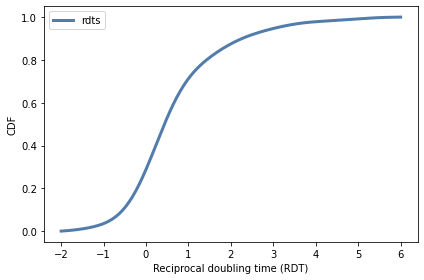

In [61]:
from utils import decorate

cdf_rdt.plot(label='rdts')

decorate(xlabel='Reciprocal doubling time (RDT)',
         ylabel='CDF')

To generate a random value from the distribution, we can use `Pmf.choice`:

In [26]:
kde_rdt.choice()

-0.24

To generate a sequence of random values, I'll use the following generator function.
If you are not familiar with generator functions, you can [read about them here](https://wiki.python.org/moin/Generators).


In [32]:
def uncorrelated_generator(pmf, rho=None):
    """Generates a sequence of values from pmf.

    pmf: distribution to choose from
    rho: ignored
    """
    while True:
        yield pmf.choice()

For the current version of the model, using a generator function isn't really necessary, but for the next version it will turn out to be convenient.

When we call `uncorrelated_generator`, it returns a generator object:

In [62]:
rdt_gen = uncorrelated_generator(kde_rdt)
rdt_gen

<generator object uncorrelated_generator at 0x7f35835164a0>

The generator behaves like a iterator, so we can use it in a `for` loop, or we can use `next` to get the next value.

For example, here's a function that takes a generator and returns a list with the given number of values:

In [34]:
def generate_sample(gen, size=1000):
    """Get a sample from a generator.
    
    gen: generator
    size: sample size
    
    returns: list
    """
    return [next(gen) for _ in range(size)]

In [35]:
sample = generate_sample(rdt_gen)

Here's a quick test to confirm that it works:

In [36]:
from empiricaldist import Cdf

cdf_sample = Cdf.from_seq(sample)

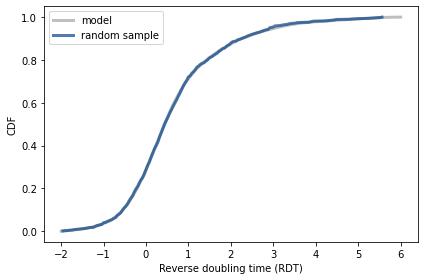

In [38]:
cdf_rdt.plot(label='model', color='C5')
cdf_sample.plot(label='random sample')

decorate(xlabel='Reciprocal doubling time (RDT)',
         ylabel='CDF')

With that, we have everything we need to simulate the growth of a tumor.

## Simulation

For the initial diameter I chose 0.3 cm, because carcinomas smaller than that are less likely to be invasive and less likely to have the blood supply needed for rapid growth (see [this page on carcinoma](http://en.wikipedia.org/wiki/Carcinoma_in_situ)).

I chose an interval of 245 days (about 8 months) because that is the
median time between measurements in the data source.

For the maximum diameter I chose 20 cm. 
In the data source, the range of observed sizes is 1.0 to 12.0 cm, so we are extrapolating beyond the observed range at each end, but not by far, and not in a way likely to have a strong effect on the results.

In [70]:
interval = 245 / 365      # year
min_diameter = 0.3        # cm
max_diameter = 20         # cm

I'll use `calc_volume` to compute the initial and maximum volumes:

In [71]:
v0 = calc_volume(min_diameter)
vmax = calc_volume(max_diameter)
v0, vmax

(0.014137166941154066, 4188.790204786391)

The following function runs the simulation.

In [74]:
import pandas as pd

def simulate_growth(rdt_gen):
    """Simulate the growth of a tumor.
    
    rdt_gen: generator that yields RDT
    
    returns: DataFrame
    """
    age = 0
    volume = v0
    res = []
    
    for rdt in rdt_gen:
        res.append((age, volume))
        if volume > vmax:
            break

        age += interval 
        doublings = rdt * interval
        volume *= 2**doublings
        
    columns = ['age', 'volume']
    sim = pd.DataFrame(res, columns=columns)
    sim['diameter'] = calc_diameter(sim['volume'])
    return sim

`simulate_growth` takes as a parameter a generator that yields reciprocal doubling times (RDT).

It initializes the age and volume of the tumor, then runs a loop that simulates one interval at a time.

Each time through the loop, it checks the volume of the tumor and exits when it exceeds `vmax`.

Then it updates `age` and `volume`.  Since `rdt` is in doublings per year, we multiply by `interval` to get compute the number of doublings during each interval.

At the end of the loop, `simulate_growth` puts the results in a `DataFrame` and computes the diameter that corresponds to each volume.

Here's how we call this function:

In [83]:
np.random.seed(17)

In [84]:
rdt_gen = uncorrelated_generator(kde_rdt)
sim = simulate_growth(rdt_gen)

And here are the results for the first few intervals:

In [85]:
sim.head()

,age,volume,diameter
0,0.000000,0.014137,0.300000
1,0.671233,0.014403,0.301867
2,1.342466,0.018345,0.327220
3,2.013699,0.016715,0.317226
4,2.684932,0.012182,0.285475


And the last few intervals.

In [86]:
sim.tail()

,age,volume,diameter
45,30.205479,651.531735,10.755873
46,30.876712,1117.703474,12.875852
47,31.547945,3053.365946,17.999485
48,32.219178,2534.862261,16.916814
49,32.890411,4684.628855,20.759913


The simulation is based on one big simplification: the growth rate is
chosen independently during each interval, so it does not depend on age, size, or growth rate during previous intervals.

In Section xxx I
review these assumptions and consider more detailed models. But first
let's look at some examples.

The following figure shows the size of simulated tumors as a
function of age. The dashed line at 10 cm shows the range of ages for
tumors at that size: the fastest-growing tumor gets there in 8 years;
the slowest takes more than 35.

To show the results graphically, I'll run 101 simulations:

In [87]:
np.random.seed(17)

In [88]:
rdt_gen = uncorrelated_generator(kde_rdt)
sims = [simulate_growth(rdt_gen) for _ in range(101)]

Here's what the results look like:

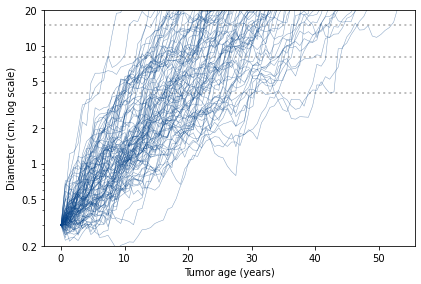

In [89]:
import matplotlib.pyplot as plt

diameters = [4, 8, 15]
for diameter in diameters:
    plt.axhline(diameter, color='C5', 
                linewidth=2, linestyle='dotted')

for sim in sims:
    plt.plot(sim['age'], sim['diameter'],
             color='C0', linewidth=0.5, alpha=0.5)
    
decorate(xlabel='Tumor age (years)',
         ylabel='Diameter (cm, log scale)',
         ylim=[0.2, 20],
         yscale='log')

yticks = [0.2, 0.5, 1, 2, 5, 10, 20]
plt.yticks(yticks, yticks);

In [90]:
from scipy.interpolate import interp1d
from empiricaldist import Pmf

def interpolate_ages(sims, diameter):
    ages = []
    for sim in sims:
        interp = interp1d(sim['diameter'], sim['age'])
        age = interp(diameter)
        ages.append(float(age))
    return ages

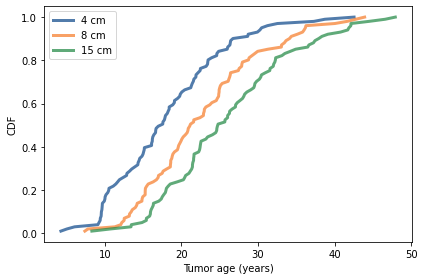

In [91]:
for diameter in diameters:
    ages = interpolate_ages(sims, diameter)
    cdf = Cdf.from_seq(ages)
    cdf.plot(label=f'{diameter} cm')
    
decorate(xlabel='Tumor age (years)',
         ylabel='CDF')

## Serial Correlation

The results so far are based on a number of modeling decisions; let's
review them and consider which ones are the most likely sources of
error:

* To convert from linear measure to volume, we assume that tumors are approximately spherical. This assumption is probably fine for tumors up to a few centimeters, but not for very large tumors.

* The distribution of growth rates in the simulations are based on a
    continuous model we chose to fit the data reported by Zhang et al,
    which is based on 53 patients. The fit is only approximate and, more importantly, a larger sample would yield a different distribution.

* The growth model does not take into account tumor subtype or grade;
    this assumption is consistent with the conclusion of Zhang et al:
    "Growth rates in renal tumors of different sizes, subtypes and
    grades represent a wide range and overlap substantially." But with a
    larger sample, a difference might become apparent.

* The distribution of growth rate does not depend on the size of the
    tumor. This assumption would not be realistic for very small and
    very large tumors, whose growth is limited by blood supply.

    But tumors observed by Zhang et al ranged from 1 to 12 cm, and they found no statistically significant relationship between size and growth rate. So if there is a relationship, it is likely to be weak, at least in this size range.

* In the simulations, growth rate during each interval is independent of previous growth rates. In reality it is plausible that tumors that have grown quickly in the past are more likely to grow quickly. In other words, there is probably a serial correlation in growth rate.

Of these, the first and last seem the most problematic. I'll investigate serial correlation first, then come back to spherical geometry.

## Correlated Growth

To simulate correlated growth, I wrote a generator[^2] that yields a
correlated series from a given Cdf. Here's how the algorithm works:

1. Generate correlated values from a Gaussian distribution. This is easy to do because we can compute the distribution of the each value conditioned on the previous value.

2. Transform each value to its cumulative probability using the Gaussian CDF.

3. Transform each cumulative probability to the corresponding value using the given `Cdf`.

Here's what that looks like in code:

## Correlated Generator

In [95]:
def correlated_generator(cdf, rho):
    """Generate correlated values from cdf.
    
    cdf: Cdf object
    rho: float -1 to 1
    """
    x = np.random.normal(0, 1)
    yield transform(x, cdf)

    sigma = np.sqrt(1 - rho**2);    
    while True:
        x = np.random.normal(x * rho, sigma)
        yield transform(x, cdf)

The first value of is Gaussian with mean 0 and standard deviation 1. For subsequent values, the mean and standard deviation depend on the
previous value. Given the previous , the mean of the next value is , and the variance is .

In [92]:
from scipy.stats import norm

def transform(z, cdf):
    """Map a standard normal variate to a CDF.
    
    z: value from a standard normal distribution
    cdf: Cdf object
    
    returns: value from cdf
    """
    p = norm.cdf(z)
    y = cdf.inverse(p)
    return float(y)

Remember that `simulate_growth` takes a generator as an argument. That interface allows it to work with different generators:

In this example, and are drawn from the same distribution, but the
values in are uncorrelated and the values in are correlated with a
coefficient of approximately .

Now we can see what effect serial correlation has on the results; the
following table shows percentiles of age for a 6 cm tumor, using the
uncorrelated generator and a correlated generator with target
$\rho = 0.4$.

Correlation makes the fastest growing tumors faster and the slowest
slower, so the range of ages is wider. The difference is modest for low
percentiles, but for the 95th percentile it is more than 6 years. To
compute these percentiles precisely, we would need a better estimate of
the actual serial correlation.

However, this model is sufficient to answer the question we started
with: given a tumor with a linear dimension of 15.5 cm, what is the
probability that it formed more than 8 years ago?

With no serial correlation, the probability that a 15.5 cm tumor is
older than 8 years is 0.999, or almost certain. With correlation 0.4,
faster-growing tumors are more likely, but the probability is still
0.995. Even with correlation 0.8, the probability is 0.978.

Another likely source of error is the assumption that tumors are
approximately spherical. For a tumor with linear dimensions 15.5 x 15
cm, this assumption is probably not valid. If, as seems likely, a tumor this size is relatively flat, it might have the same volume as a 6 cm sphere. With this smaller volume and correlation 0.8, the probability of age greater than 8 is still 95%.

So even taking into account modeling errors, it is unlikely that such a large tumor could have formed less than 8 years prior to the date of
diagnosis.

In [94]:
transform(1, cdf_rdt)

1.7200000000000002

In [97]:
rdt_gen = correlated_generator(cdf_rdt, 0.6)
sample = generate_sample(rdt_gen)
cdf_sample = Cdf.from_seq(sample)

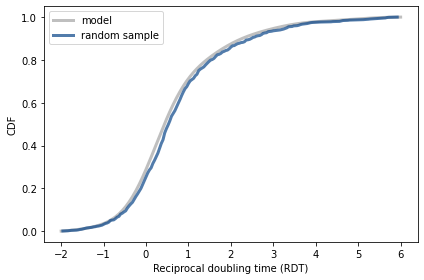

In [99]:
cdf_rdt.plot(label='model', color='C5')
cdf_sample.plot(label='random sample', color='C0')

decorate(xlabel='Reciprocal doubling time (RDT)',
         ylabel='CDF')

In [100]:
np.corrcoef(sample[1:], sample[:-1])

array([[1.       , 0.5873048],
       [0.5873048, 1.       ]])

In [105]:
rdt_gen = correlated_generator(cdf_rdt, 0.5)
sims2 = [simulate_growth(rdt_gen)
          for _ in range(101)]

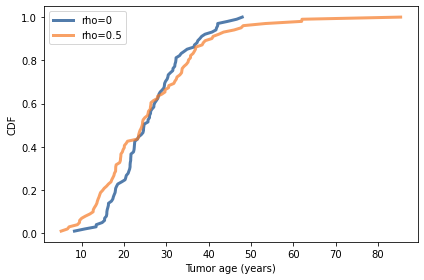

In [106]:
diameter = 15
ages = interpolate_ages(sims, diameter)
cdf = Cdf.from_seq(ages)
cdf.plot(label='rho=0')
    
ages2 = interpolate_ages(sims2, diameter)
cdf2 = Cdf.from_seq(ages2)
cdf2.plot(label='rho=0.5')
    
decorate(xlabel='Tumor age (years)',
         ylabel='CDF')

In [107]:
ps = np.array([0.05, 0.25, 0.5, 0.75, 0.95])
df = pd.DataFrame(columns=ps*100)
df.columns.name = 'Percentiles'
df.index.name = 'Correlation'

df.loc[0] = cdf.quantile(ps)
df.loc[0.6] = cdf2.quantile(ps)

df

Percentiles,5.0,25.0,50.0,75.0,95.0
Correlation,,,,,
0.0,15.420544,20.424786,24.788780,31.535889,41.868662
0.6,9.527274,17.385593,24.370874,33.675901,47.666901


## Discussion


Well, we got through a whole chapter without using Bayes's theorem or
the class that encapsulates Bayesian updates. What happened?

One way to think about Bayes's theorem is as an algorithm for inverting
conditional probabilities. Given , we can compute , provided we know and
. Of course this algorithm is only useful if, for some reason, it is
easier to compute than .

In this example, it is. By running simulations, we can estimate the
distribution of size conditioned on age, or . But it is harder to get
the distribution of age conditioned on size, or . So this seems like a
perfect opportunity to use Bayes's theorem.

The reason I didn't is computational efficiency. To estimate for any
given size, you have to run a lot of simulations. Along the way, you end
up computing for a lot of sizes. In fact, you end up computing the
entire joint distribution of size and age, .

And once you have the joint distribution, you don't really need Bayes's
theorem, you can extract by taking slices from the joint distribution,
as demonstrated in .

So we side-stepped Bayes, but he was with us in spirit.

[^1]: Zhang et al, Distribution of Renal Tumor Growth Rates Determined
    by Using Serial Volumetric CT Measurements, January 2009
    *Radiology*, 250, 137-144.
    
https://pubs.rsna.org/doi/full/10.1148/radiol.2501071712

[^2]: If you are not familiar with Python generators, see
    <http://wiki.python.org/moin/Generators>.

In [ ]:
from scipy.stats import expon
from empiricaldist import Pmf

def expo_pmf(xs, lam):
    ps = expon.pdf(xs, scale=1/lam)
    pmf = Pmf(ps, xs)
    pmf.normalize()
    return pmf

In [ ]:
pc = 0.55
lam1 = 2.5
lam2 = 0.7

In [ ]:
from scipy.stats import expon
from utils import pmf_from_dist

x1 = np.arange(0, 2, 0.1)
pmf1 = expo_pmf(x1, lam1).transform(lambda x: -x)

x2 = np.arange(0, 7, 0.1)
pmf2 = expo_pmf(x2, lam2)

In [ ]:
pmf_model = pc * pmf1 + (1-pc) * pmf2
cdf_model = pmf_model.make_cdf()

In [ ]:
from utils import decorate

cdf_model.plot(label='model', color='C5')
cdf_rdt.plot(label='data', style='s')

decorate(xlabel='Reciprocal doubling time (RDT)',
         ylabel='CDF')